# Biased Coin Toss
by Nicholas Archambault

### Original Question
Suppose you want to generate a sample of heads and tails from a fair coin, but you only have a biased coin available (meaning the probability of coming up with heads is different than 1/2).

Write a simulation in Python that will use your biased coin to generate a sample of heads and tails as if it were coming from a fair coin.

### Solution
The question asks us to confront a tricky challenge: generating a fair distribution of heads and tails results from a biased coin whose weight we do not know. 

Given that we must use the unbiased coin to produce a faux fair coin, it seems we ought to create a pipeline of functions that build on one another. 

There is no data to read in, but we can import `numpy`, which will assuredly be necessary for manipulating randomized distributions, as well as `matplotlib`, since the results of repeated simulations under different conditions can lead to a plethora of interesting visualizations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for figures
plt.rcParams['figure.dpi'] = 100

As a first step, we'll want to set a global probability that will serve as the biased 'threshold' for determining a result of heads or tails from our coin flip. Given that the prompt does not specify whether the threshold varies with each run, we could choose our own static threshold – say, the probability of heads $P(H) = 0.8$. It might be more interesting, however, to repeatedly redefine a randomized threshold with the `np.random.rand()` function, which generates a random value from between 0 and 1. This is akin to using a different biased coin with a different weight on each toss.

In [2]:
prob = np.random.rand()

The first function in the pipeline simulates the biased toss. We simply define the coin's weight as whatever randomly-chosen value is assigned to `prob`, then return a 1 for heads if our toss – another randomized value – exceeds that threshold.

In [3]:
def biased(p = prob):
    toss = np.random.rand()
    return 1 if toss > prob else 0

We can feed the `biased` function into a second function that will generate a fair distribution despite the weighted coin. The key to this maneuver is to consider tosses in pairs. We know that two tosses of a fair coin should result in one heads and one tails. If that exact pairing, either $HT$ or $TH$ for two successive tosses, is generated by our biased coin, the bias can be considered nullified, for the coin has produced a distribution indistinguishable from that of a fair coin.

The `fair_coin` function evaluates the current toss with respect to the previous toss. If the outcomes of both tosses are the same, they are discarded. If they are different, however, the current toss is returned as a valid result.

In [4]:
def fair_coin():
    last = biased()
    current = biased()
    
    while last == current:
        last, current = biased(), biased()
    
    return current

Having crafted a function that returns a single fair-coin result from a biased coin of unknown weight, we can now simulate the experiment any number of times to see how the distributions play out. The `get_outcomes` function tallies all heads and tails results for a specified number of tosses, then plots those results and specifies the 95% confidence interval within which we expect the probability of heads $P(H)$ to fall.

In [5]:
def get_outcomes(tosses):
    results = np.array([fair_coin() for _ in range(tosses)])
    tails, heads = (results == 0).sum(), (results == 1).sum()
    
    p = 0.5
    mu = p * tosses
    sigma = np.sqrt(p * (1 - p) * tosses)
    ci = (round((mu - 2 * sigma) / tosses, 2), round((mu + 2 * sigma) / tosses, 2))
    
    plt.bar(['Tails\nP(T) = {}'.format(round(tails / tosses, 2)), 'Heads\nP(H) = {}'.format(round(heads / tosses, 2))], [tails, heads], color = ["silver", "goldenrod"])
    plt.suptitle("Distribution of {:,} Coin Tosses".format(tosses), fontsize = 14, fontweight = "bold", y = 0.99)
    plt.title(r"95% Confidence Interval, Probability of Heads: {} $\leq$ P(H) $\leq$ {}".format(ci[0], ci[1]), fontsize = 11)
    plt.ylabel("Number of Flips")
    plt.show()

The distributions, which we expect to feature equivalent probabilities of 0.5, are highly volatile for low sample sizes. In the results below, for example, nearly all of the 10 tosses turn up tails.

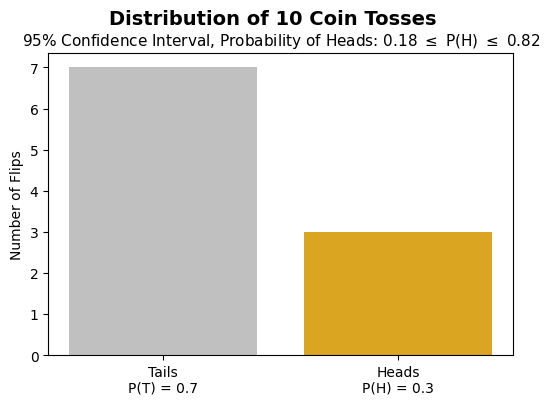

In [6]:
np.random.seed(119)
get_outcomes(10)

As we increase the number of tosses, however, the results start to converge toward expected values. 

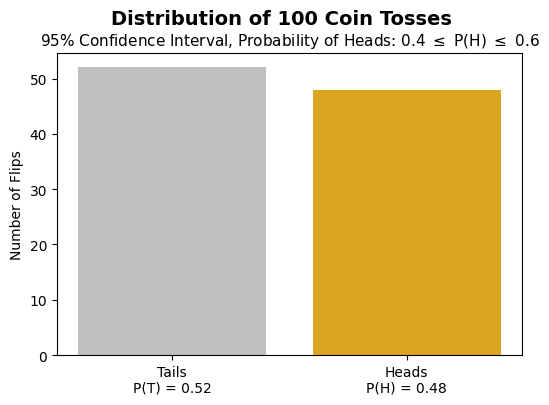

In [7]:
get_outcomes(100)

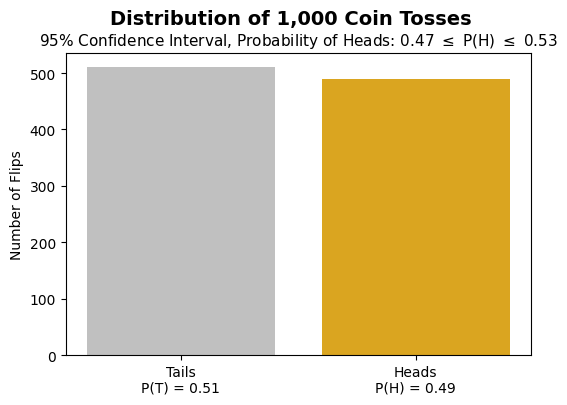

In [8]:
get_outcomes(1000)

By the time we simulate 1,000 tosses, the probabilities of heads and tails are roughly equivalent.

But it is still worth asking: just how much to these probabilities deviate across repeated 1,000-toss simulations? Do the results perfectly match our expectation once the number of tosses exceeds a certain value?

To investigate this, we can utilize a random resampling method known as *bootstrapping*. We can think of the results of `get_outcome`, which shows the probabilities $P(T)$ and $P(H)$, as a distribution. Bootstrapping resamples this distribution many times in order to compile a larger 'bootstrap distribution,' an aggregated picture of how the original distribution appears over hundreds or thousands of repeated trials. 

The method is based on the *Law of Large Numbers*, which maintains that repeated sampling should eventually result in data that resembles the true population data. The process for bootstrapping involves running the `fair_coin` function with a certain number of tosses $N$ to generate a single $P(H)$ value representing how many heads were flipped among those tosses. With this single data point in hand, we then repeat the process 10,000 times and examine how the resultant 10,000 values of $P(H)$ are distributed. 

We should find, as $N$ increases, that the range of $P(H)$ values generated tightens and converges toward the true value – the 'true population data' – of 0.5, which is marked on each plot with a maroon line.

In [9]:
def bootstrap(N, sims = 10000):
    bootstrapped = []
    
    for i in range(sims):
        results = np.array([fair_coin() for _ in range(N)])
        tails, heads = (results == 0).sum(), (results == 1).sum()
        bootstrapped.append(heads / N)
        
    plt.hist(bootstrapped, bins = 100, color = "steelblue")
    plt.axvline(0.5, color = "firebrick")
    plt.ylabel("Number of Occurrences")
    plt.xlabel("P(H)")
    plt.suptitle("Distribution of Bootstrapped P(H)", fontsize = 14, fontweight = "bold", y = 0.99)
    plt.title("{:,} Iterations of {:,} Tosses".format(sims, N), fontsize = 11)
    plt.show()

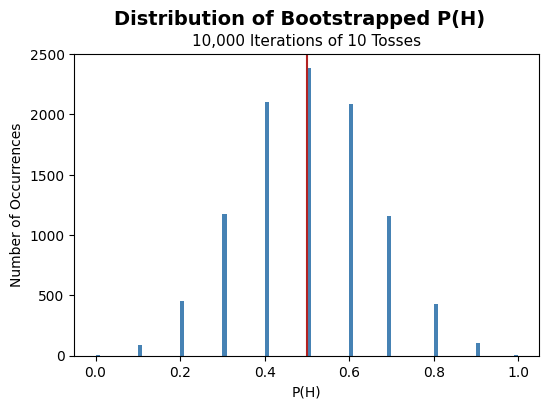

In [10]:
bootstrap(10)

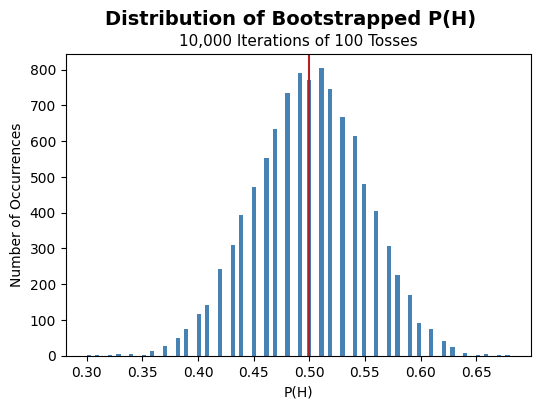

In [11]:
bootstrap(100)

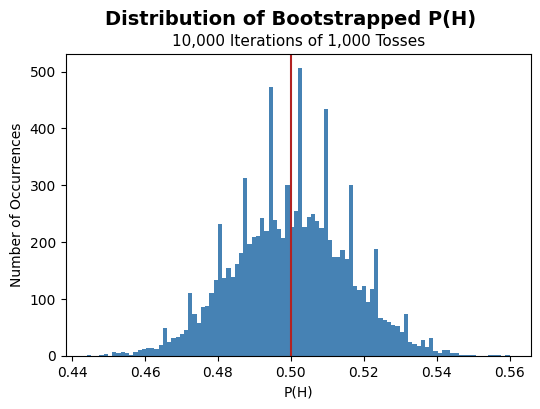

In [12]:
bootstrap(1000)

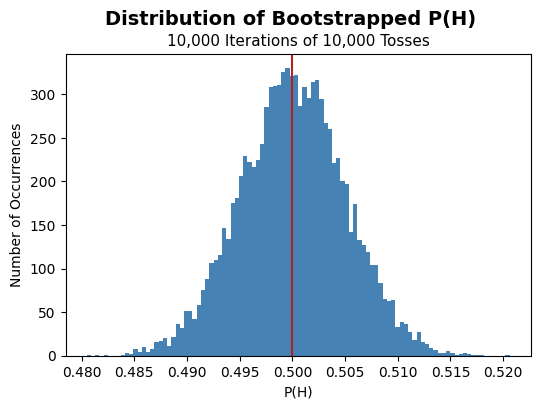

In [13]:
bootstrap(10000)

As the number of fair coin tosses exponentially increases, we find that bootstrapping corroborates our assumptions. With 10 tosses, the majority of the 10,000 $P(H)$ values are concentrated around the true value, 0.5. But there are still plenty of outliers at the fringes, as labeled along the x-axis, including some uniform results where all 10 tosses went either heads or tails. This trend perpetuates for 100 tosses, though the range of outcomes tightens. We observe zero cases when tosses were uniformly heads or tails, and the range of $P(H)$ values is constricted between 0.3 and 0.7.

With 10,000 tosses, the distribution has converged around the expected value of 0.5 in alignment with the behavior we anticipated. For 10,000 iterations of 10,000 coin tosses each, almost every iteration yields a $P(H)$ that falls within the window between 0.48 and 0.52. This is strong evidence that we have indeed created a distribution of fair coin outcomes from a randomly-weighted biased coin.